# ARIMA Work

In [130]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import pickle
import matplotlib.pyplot as plt
from pymongo import MongoClient
import time
import datetime
import os
import itertools
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import scipy.stats as scs
import warnings # We get some interger -> float typecast warning from sklean
warnings.filterwarnings('ignore')
from plot_series_arima import fit_moving_average_trend, plot_raw, plot_moving_average, plot_resid, tots, fromts
from time_series import to_timeseries

In [3]:
plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [137]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)

#### Make _series_ a series of AK-47 | Redline (Field-Tested) sales after 2015 with dates as the index

In [6]:
df_gun = df[(df['item_name'] == 'AK-47 | Redline (Field-Tested)')]
df_gun.date = [datetime.datetime.fromtimestamp(t) for t in df_gun.date]
df_gun.index= df_gun.date
series = df_gun.median_sell_price
series = series.loc[pd.Timestamp('2015-01-01'):]

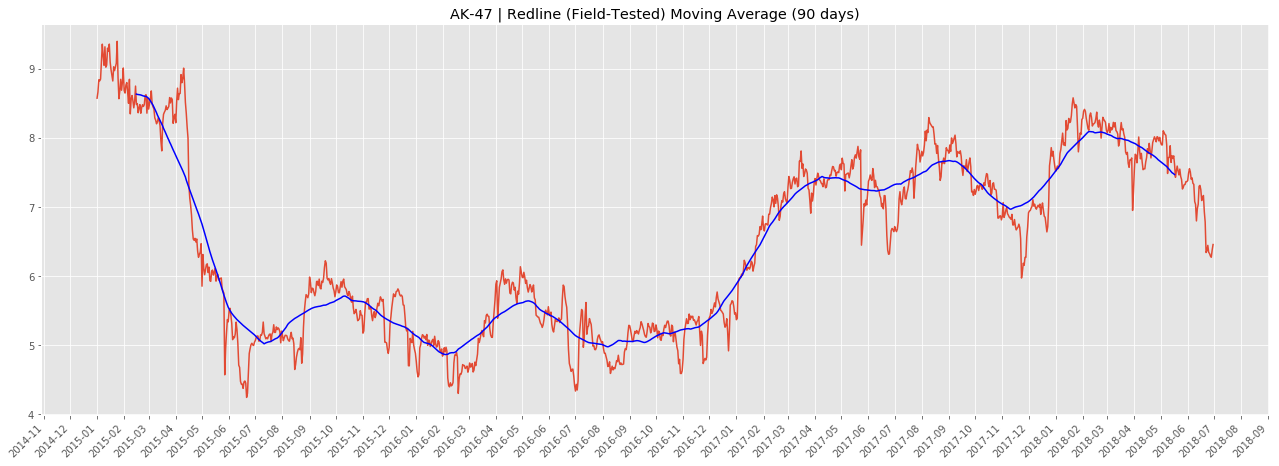

In [13]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
plot_moving_average(series, ax, title='AK-47 | Redline (Field-Tested)', window=90)

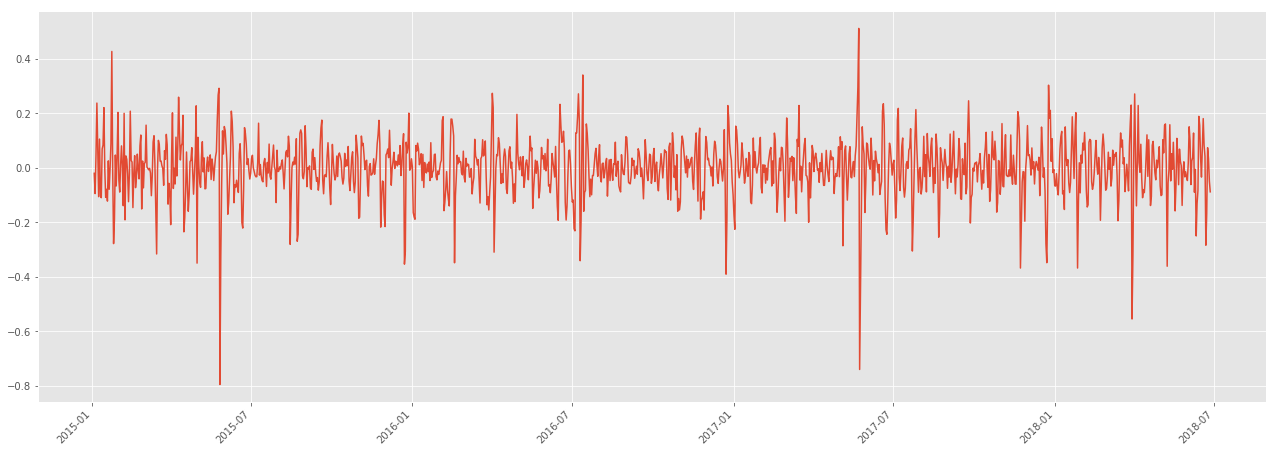

In [42]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
_=ax.plot(series.index, sm.tsa.seasonal_decompose(series).resid)

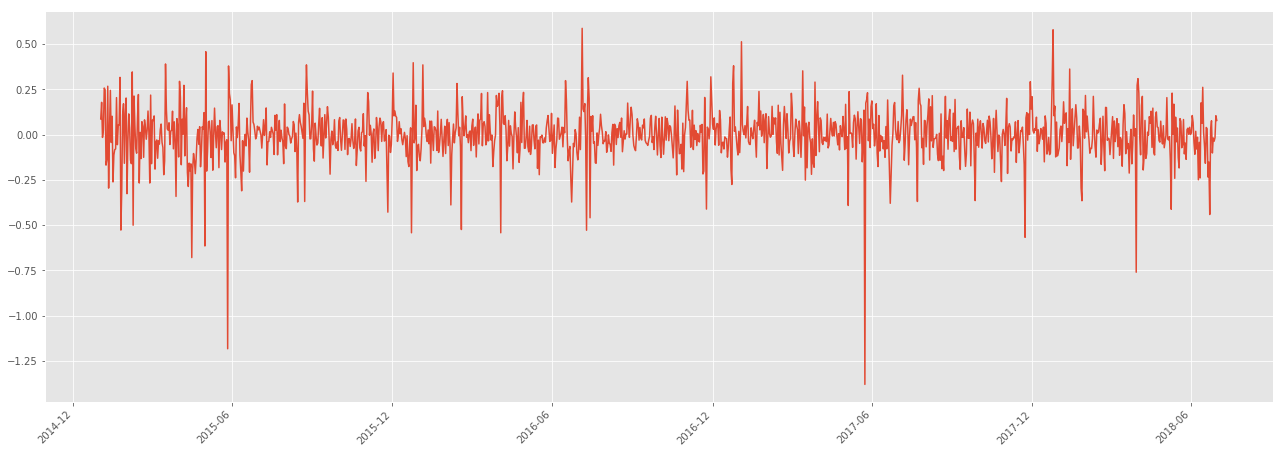

In [43]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
ax.plot(series.index, series.diff())

In [54]:
sm.tsa.stattools.adfuller(series.diff()[1:-1])

(-10.646873080727838,
 4.770691603761387e-19,
 13,
 1261,
 {'1%': -3.4355464009607255,
  '5%': -2.8638347524449888,
  '10%': -2.5679917506718044},
 -1381.897779557889)

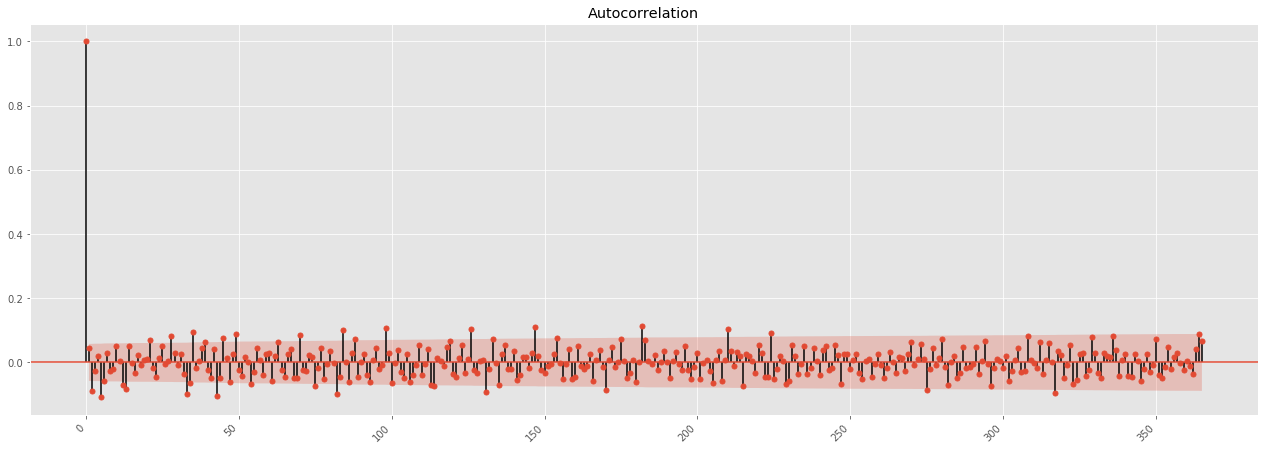

In [85]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
_=sm.graphics.tsa.plot_acf(series[121:].diff()[1:], lags=365, ax=ax)

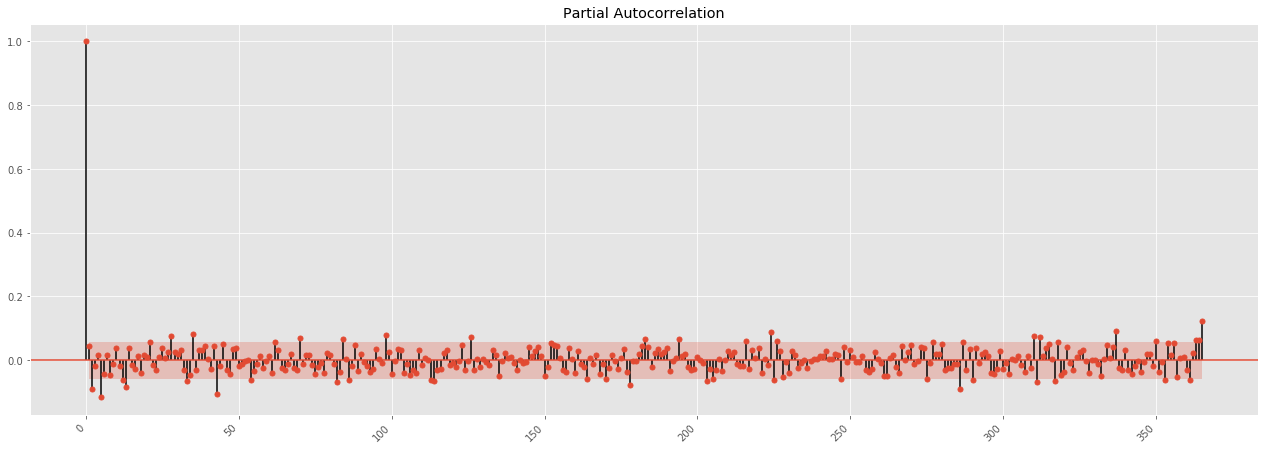

In [84]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
_=sm.graphics.tsa.plot_pacf(series[121:].diff()[1:], lags=365, ax=ax)

In [87]:
model = ARIMA(series[121:], order=(3,1,0)).fit()

In [88]:
model.params

const                        0.000129
ar.L1.D.median_sell_price    0.048308
ar.L2.D.median_sell_price   -0.089633
ar.L3.D.median_sell_price   -0.018425
dtype: float64

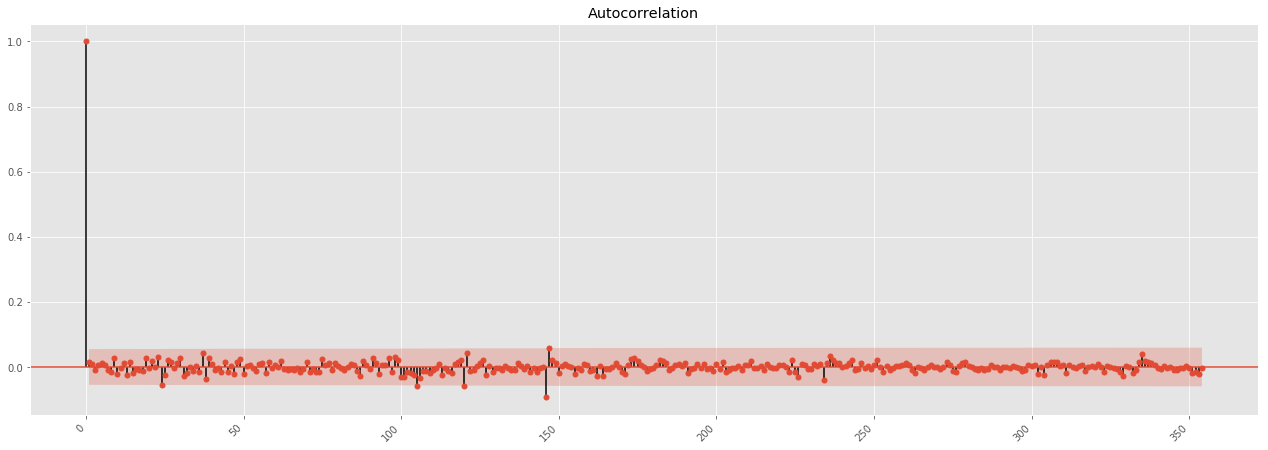

In [100]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
_=sm.graphics.tsa.plot_acf(model.resid(), lags=354, ax=ax)

In [131]:
from pyramid.arima import auto_arima
model = auto_arima(series)

NameError: name 'series' is not defined

In [95]:
model.resid

<function pyramid.arima.arima.ARIMA.resid(self)>

In [98]:
model.params()

array([-0.00406217, -0.4438544 , -0.99798583,  0.43461036,  0.99305218,
        0.01905795])

In [101]:
model.aic()

-1417.253215224525

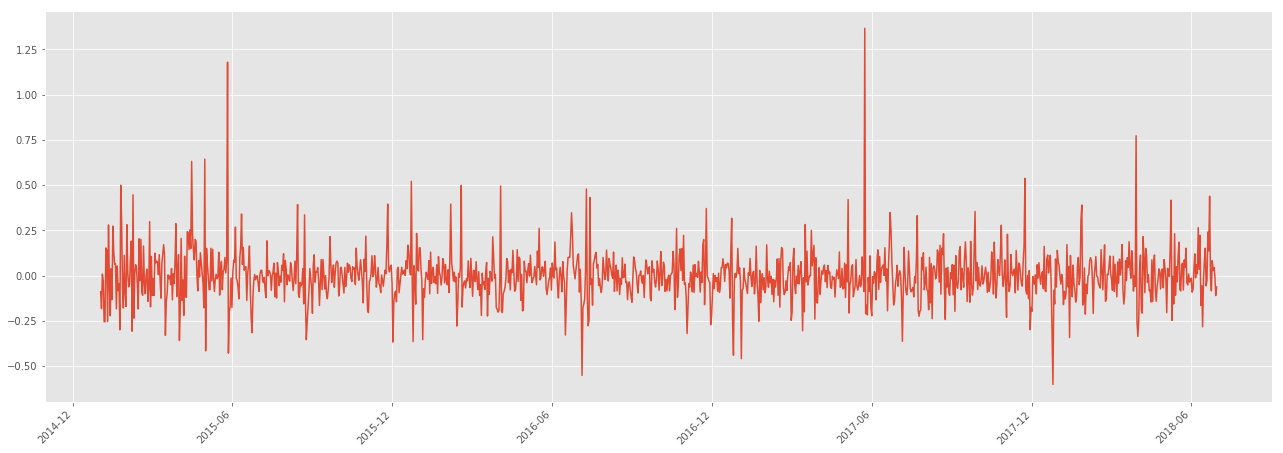

In [114]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
#plot_raw(series, ax)
#ax.plot(series.index, series.values)
ax.plot(series.index[1:], model.predict_in_sample(start=1) - series.values[1:])

In [116]:
res = model.predict_in_sample(start=1) - series.values[1:]

In [124]:
series[np.argsort(res)][:-2:-1]

date
2017-05-23    7.825
Name: median_sell_price, dtype: float64

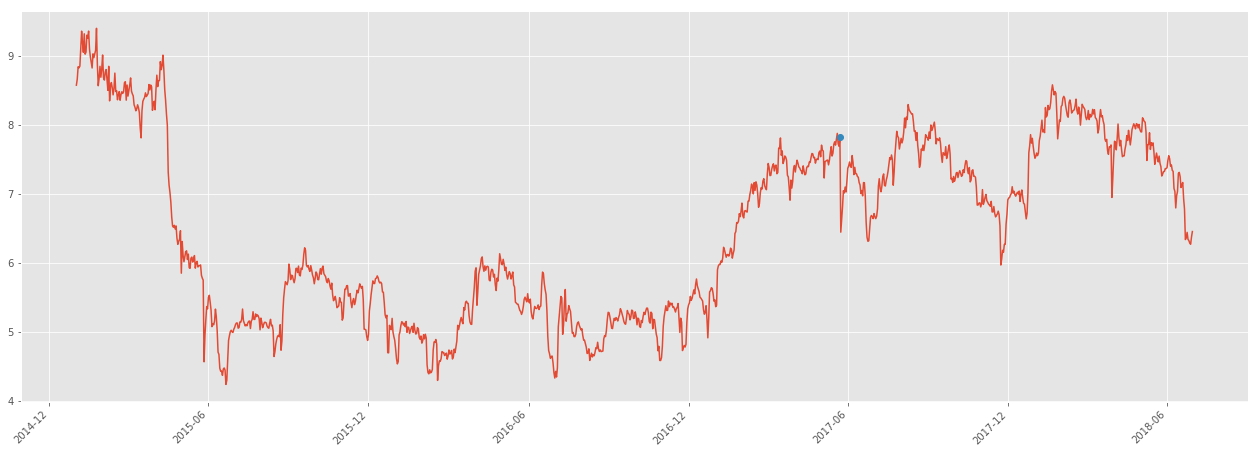

In [136]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
ax.plot(series.index, series.values)
_=ax.plot(series.index[np.argsort(res)[:-2:-1]], series[np.argsort(res)[:-2:-1]], marker='o')

In [126]:
series[np.argsort(res)][:-2:-1]

date
2017-05-23    7.825
Name: median_sell_price, dtype: float64

In [131]:
series.index[np.argsort(res)][:-2:-1]

DatetimeIndex(['2017-05-23'], dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
np.argsort(res)][:-2:-1]

In [250]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -257.740
Date:                Fri, 10 Aug 2018   AIC                            527.481
Time:                        10:58:43   BIC                            543.683
Sample:                             0   HQIC                           534.053
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2584      0.232     -1.114      0.265      -0.713       0.196
ar.L1          1.1515      0.127      9.055      0.000       0.902       1.401
ar.L2         -0.8882      0.115     -7.702      0.000      -1.114      -0.662
ma.L1         -0.9784      0.180     -5.423      0.000      -1.332      -0.625
ma.L2          0.7163      0.200      3.585      0.000       0.325       1.108
sigma2         6.3164      0.453     13.930      0.000       5.428       7.205
===================================================================================
Ljung-Box (Q):                       21.87   Jarque-Bera (JB):               673.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -2.20
Prob(H) (two-sided):                  0.25   Kurtosis:                        14.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [142]:
dfpubg = df[df.app == 578080]
dfpubg = dfpubg[dfpubg.item_name == 'Leather Hoodie (White)']

In [143]:
dfpubg.index = [fromts(t) for t in dfpubg.date]

### For the Leather Hoodie the auto-arima resid always gave the first entry as being the largest outlier

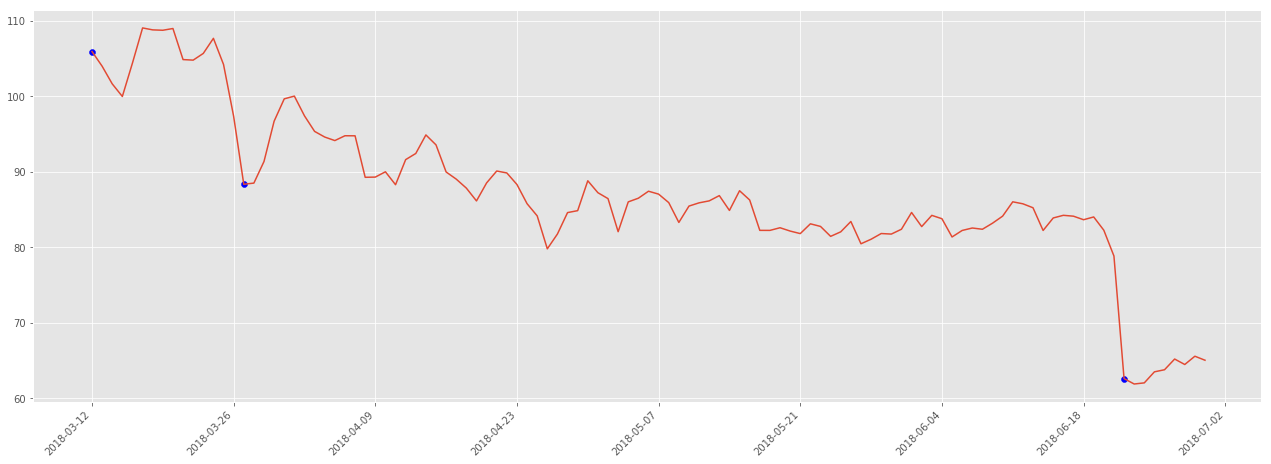

In [161]:
series = dfpubg.median_sell_price
series = series.iloc[60:]
model = auto_arima(series)
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
ax.plot(series.index, series.values)
_=ax.scatter(series.index[np.argsort(abs(model.resid()))[:-4:-1]], series[np.argsort(abs(model.resid()))[:-4:-1]], marker='o', c='b')

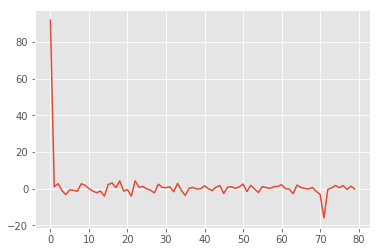

In [154]:
plt.plot(model.resid())

In [162]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -257.740
Date:                Thu, 09 Aug 2018   AIC                            527.481
Time:                        22:36:40   BIC                            543.683
Sample:                             0   HQIC                           534.053
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2584      0.232     -1.114      0.265      -0.713       0.196
ar.L1          1.1515      0.127      9.055      0.000       0.902       1.401
ar.L2         -0.8882      0.115     -7.702      0.000      -1.114      -0.662
ma.L1         -0.9784      0.180     -5.423      0.000      -1.332      -0.625
ma.L2          0.7163      0.200      3.585      0.000       0.325       1.108
sigma2         6.3164      0.453     13.930      0.000       5.428       7.205
===================================================================================
Ljung-Box (Q):                       21.87   Jarque-Bera (JB):               673.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -2.20
Prob(H) (two-sided):                  0.25   Kurtosis:                        14.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [195]:
df_gun = df[(df['item_name'] == 'AK-47 | Redline (Field-Tested)')]
df_gun.date = [datetime.datetime.fromtimestamp(t) for t in df_gun.date]
df_gun.index= df_gun.date
a = df_gun.median_sell_price
a = a.loc[pd.Timestamp('2016-01-01'):pd.Timestamp('2018-01-01')]

df_gun = df[(df['item_name'] == 'Five-SeveN | Monkey Business (Minimal Wear)')]
df_gun.date = [datetime.datetime.fromtimestamp(t) for t in df_gun.date]
df_gun.index= df_gun.date
b = df_gun.median_sell_price
b = b.loc[pd.Timestamp('2016-01-01'):pd.Timestamp('2018-01-01')]

In [197]:
a.corr(b)

0.6828787327002803

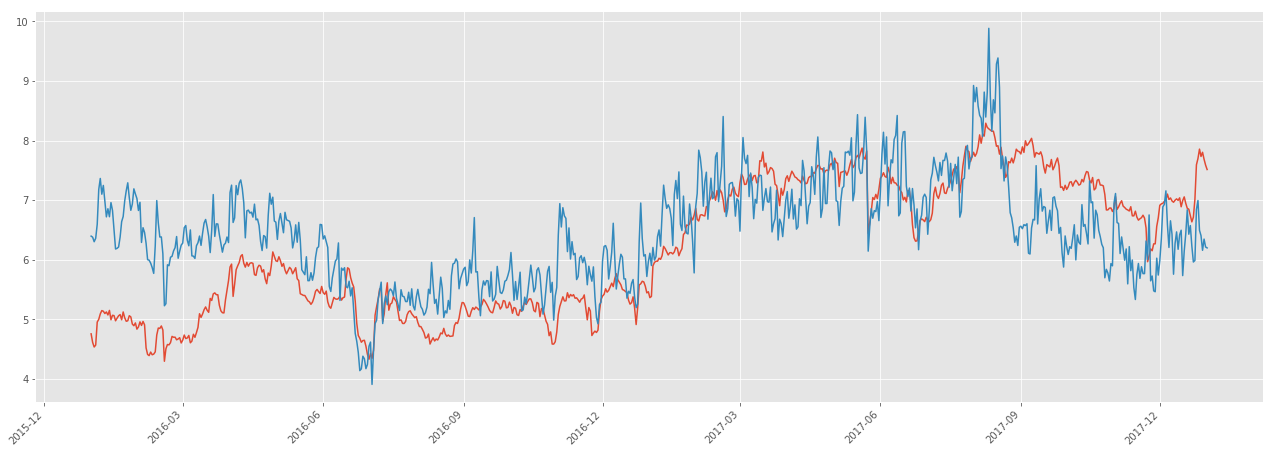

In [198]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
ax.plot(a.index, a)
ax.plot(b.index, b)

In [232]:
df_high_quant = df[df.groupby('item_name').transform('mean').quantity > 100]
df_price = df_high_quant[df_high_quant.groupby('item_name').transform('min').median_sell_price > .8]
df_price = df_price[df_price.groupby('item_name').transform('max').median_sell_price - df_price.groupby('item_name').transform('min').median_sell_price > .5]
df_time = df_price[df_price.groupby('item_name').transform('min').date < 1451628000.0]

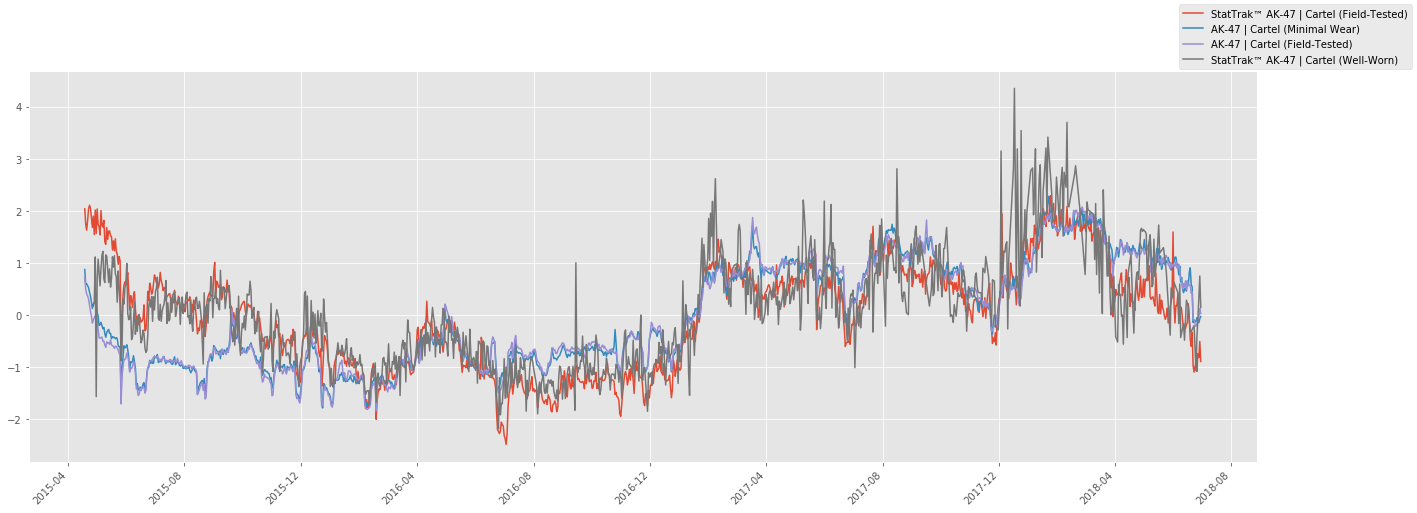

In [249]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
# for x in np.random.choice(df_time[df_high_quant.app == 730].item_name.unique(), size=5):
for x in ['StatTrak™ AK-47 | Cartel (Field-Tested)', 'AK-47 | Cartel (Minimal Wear)', 'AK-47 | Cartel (Field-Tested)', 'StatTrak™ AK-47 | Cartel (Well-Worn)']:
    ts = to_timeseries(df, x).iloc[100:]
    ts = (ts - np.mean(ts)) / np.std(ts)
    ax.plot(ts.index, ts, label=x)
fig.legend()

In [223]:
tots('Jan 01 2016')

1451628000.0

In [240]:
for x in ['AK-47 | Cartel (Factory New)', 'AK-47 | Cartel (Minimal Wear)', 'AK-47 | Cartel (Field-Tested)', 'AK-47 | Cartel (Well-Worn)']:
    print(len(to_timeseries(df_time, x).iloc[100:]))

1169
1169
1169
0


In [247]:
to_timeseries(df_time, 'AK-47 | Cartel (Minimal Wear)').iloc[100:].corr(to_timeseries(df, 'StatTrak™ AK-47 | Cartel (Field-Tested)').iloc[100:])

0.7663857550059743

In [246]:
to_timeseries(df, 'StatTrak™ AK-47 | Cartel (Field-Tested)')

date
2015-01-09    128.701
2015-01-10     86.499
2015-01-11     65.226
2015-01-12     65.384
2015-01-13     63.195
2015-01-14     68.454
2015-01-15     61.701
2015-01-16     61.060
2015-01-17     56.804
2015-01-18     47.591
2015-01-19     48.407
2015-01-20     46.707
2015-01-21     42.301
2015-01-22     43.432
2015-01-23     44.568
2015-01-24     45.677
2015-01-25     42.659
2015-01-26     41.579
2015-01-27     40.313
2015-01-28     40.334
2015-01-29     43.230
2015-01-30     40.377
2015-01-31     40.294
2015-02-01     39.221
2015-02-02     38.870
2015-02-03     37.150
2015-02-04     39.084
2015-02-05     37.905
2015-02-06     37.886
2015-02-07     38.251
               ...   
2018-06-01     15.658
2018-06-02     12.623
2018-06-03     11.784
2018-06-04     12.525
2018-06-05     12.523
2018-06-06     12.986
2018-06-07     12.004
2018-06-08     12.219
2018-06-09     12.473
2018-06-10     12.355
2018-06-11     11.876
2018-06-12     11.594
2018-06-13     11.539
2018-06-14     11.549
2018-

In [256]:
model.resid().mean() + 3*model.resid().std()

32.0051132564475

In [258]:
df.head()

,app,date,item_name,median_sell_price,quantity
0,614910,1.500613e+09,"Letters, vol. 2: L (Carrot)",0.133,1
1,614910,1.500786e+09,"Letters, vol. 2: L (Carrot)",0.130,2
2,614910,1.501304e+09,"Letters, vol. 2: L (Carrot)",0.096,1
3,614910,1.501391e+09,"Letters, vol. 2: L (Carrot)",0.102,3
4,614910,1.501564e+09,"Letters, vol. 2: L (Carrot)",0.080,1


In [270]:
df.groupby('item_name').transform({'median_sell_price':'median', 'quantity': 'mean', 'date': 'median', 'app':'median'}).head()

TypeError: unhashable type: 'dict'

In [260]:
g=df.groupby('item_name')

In [266]:
df.transform({'median_sell_price':'median', 'quantity': 'mean', 'date': 'median', 'app':'median'}).head()

ValueError: transforms cannot produce aggregated results

In [ ]:
df2 = df_test[['a']].join(df_test.groupby('a').agg({'b':my_fct1,'c':my_fct2}), on='a')
print (df2)

In [271]:
df.date.iget(0)

AttributeError: 'Series' object has no attribute 'iget'

In [299]:
df_2 = df[(df['item_name'] == 'AK-47 | Redline (Field-Tested)')]

In [300]:
df_2 = df_2[['date', 'median_sell_price']].reset_index(drop=True)

In [301]:
df_2.head()

,date,median_sell_price
0,1.392962e+09,41.405
1,1.393049e+09,35.080
2,1.393135e+09,33.149
3,1.393222e+09,36.266
4,1.393308e+09,40.936


In [302]:
df_2.columns = ['timestamp', 'count']

In [305]:
df_2.head()

,timestamp,count
0,1.392962e+09,41.405
1,1.393049e+09,35.080
2,1.393135e+09,33.149
3,1.393222e+09,36.266
4,1.393308e+09,40.936


In [307]:
df_2.set_index('timestamp', drop=True)
df_2.head()

,timestamp,count
0,1.392962e+09,41.405
1,1.393049e+09,35.080
2,1.393135e+09,33.149
3,1.393222e+09,36.266
4,1.393308e+09,40.936


In [298]:
np.datetime64(datetime.datetime.fromtimestamp(1.392962e+09).date())

numpy.datetime64('2014-02-20')

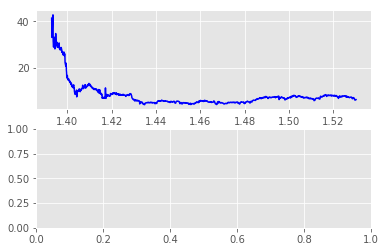

In [308]:
f, ax = plt.subplots(2, 1)
ax[0].plot(df_2['timestamp'], df_2['count'], 'b')

In [1]:
from pyculiarity import detect_ts, detect_vec
from pyculiarity.date_utils import get_gran
from pyculiarity.detect_anoms import detect_anoms
import pyculiarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import datetime
%matplotlib inline
plt.style.use('ggplot')

__author__ = 'willmcginnis'

with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [188]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)
df = df[(df['item_name'] == 'AK-47 | Redline (Field-Tested)')]
df = df[df.date > 1420092000.0]
df = df[['date', 'median_sell_price']].reset_index(drop=True)
df.columns = ['timestamp', 'count']
df.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in df.timestamp]

In [197]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)
df = df[(df['item_name'] == 'StatTrak™ AK-47 | Cartel (Field-Tested)')]
df = df[df.date > 1420092000.0]
df = df[['date', 'median_sell_price']].reset_index(drop=True)
df.columns = ['timestamp', 'count']
df.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in df.timestamp]

In [199]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)
from heapq import nlargest
for item in np.random.choice(df.item_name.unique(), 5):
    df2 = df[(df['item_name'] == item)]
    df2 = df2[df2.date > 1420092000.0]
    df2 = df2[['date', 'median_sell_price']].reset_index(drop=True)
    df2.columns = ['timestamp', 'count']
    df2.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in df2.timestamp]
    col = df2.iloc[:,0]
    n = len(col)

    largest = nlargest(n, col)
    for x, y in zip(largest[1:], largest[:-1]):
        if int(round(np.timedelta64(y - x) / np.timedelta64(1, 's'))) != 86400:
            print(int(round(np.timedelta64(y - x) / np.timedelta64(1, 's'))))
            print(item)
            break

-1036800
White Tiger Hunter
-3888000
Autographed Wrecking Ball
-10886400
Festive Killstreak Pumpkin Patch Sniper Rifle (Minimal Wear)


In [176]:
results = detect_ts(df, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)

# format the twitter data nicely
df['timestamp'] = pd.to_datetime(df['timestamp'])

Text(0,0.5,'Anomaly Magnitude')

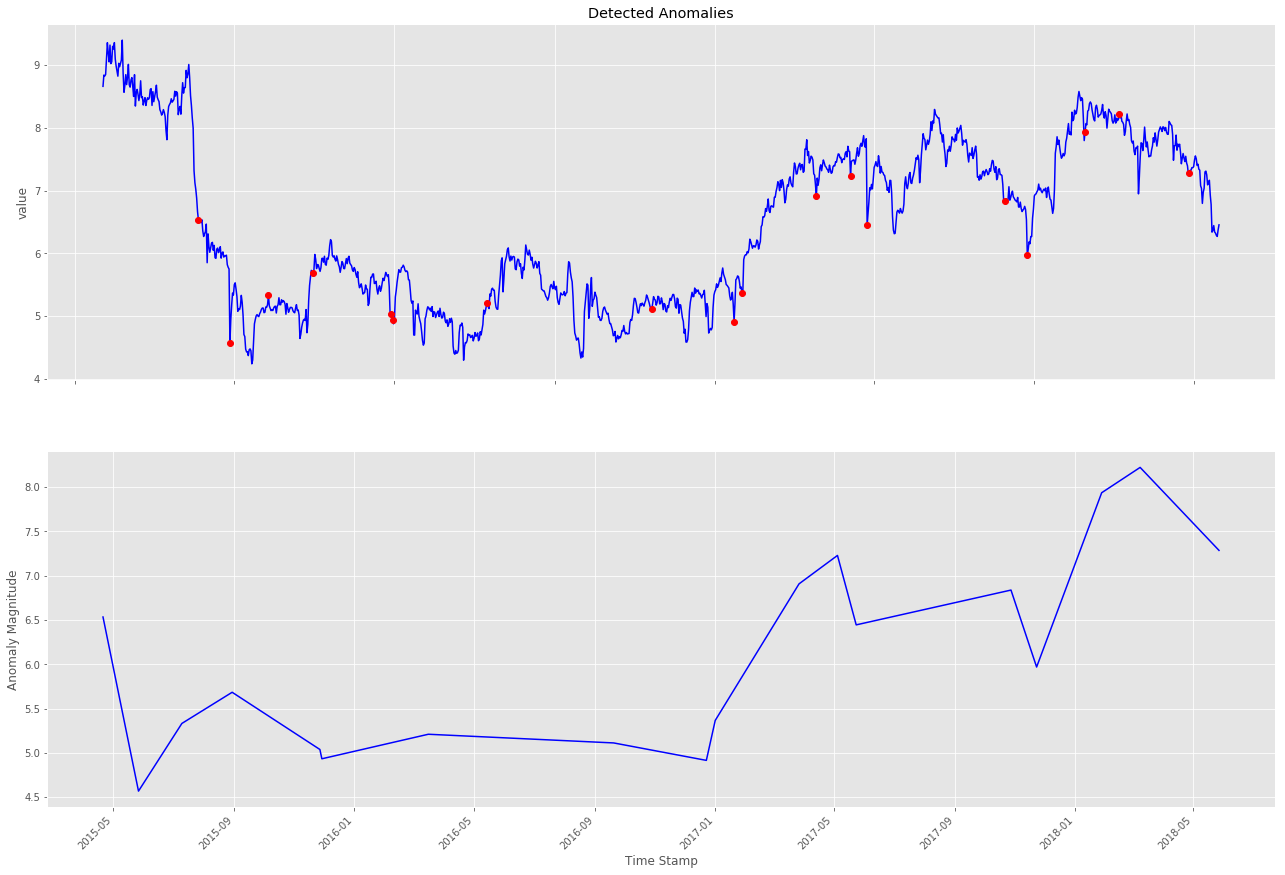

In [177]:
# make a nice plot
fig, ax = plt.subplots(2, 1, figsize=(22, 16))
fig.autofmt_xdate(rotation=45)
ax[0].plot(df['timestamp'], df['value'], 'b')
ax[0].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax[0].set_title('Detected Anomalies')
ax[1].set_xlabel('Time Stamp')
ax[0].set_ylabel('value')
ax[1].plot(results['anoms'].index, results['anoms']['anoms'], 'b')
ax[1].set_ylabel('Anomaly Magnitude')

In [153]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)
df = df[(df['item_name'] == 'AK-47 | Redline (Field-Tested)')]
df = df[df.date > 1420092000.0]
df = df[['date', 'median_sell_price']].reset_index(drop=True)
df.columns = ['timestamp', 'count']
df.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in df.timestamp]

In [154]:
results = detect_vec(df['count'], period=20, max_anoms=0.05, alpha=0.01, direction='both', only_last=False, longterm_period=60, verbose=True)

# format the twitter data nicely
df['timestamp'] = pd.to_datetime(df['timestamp'])

(3.9832499999999995, 9.65375)

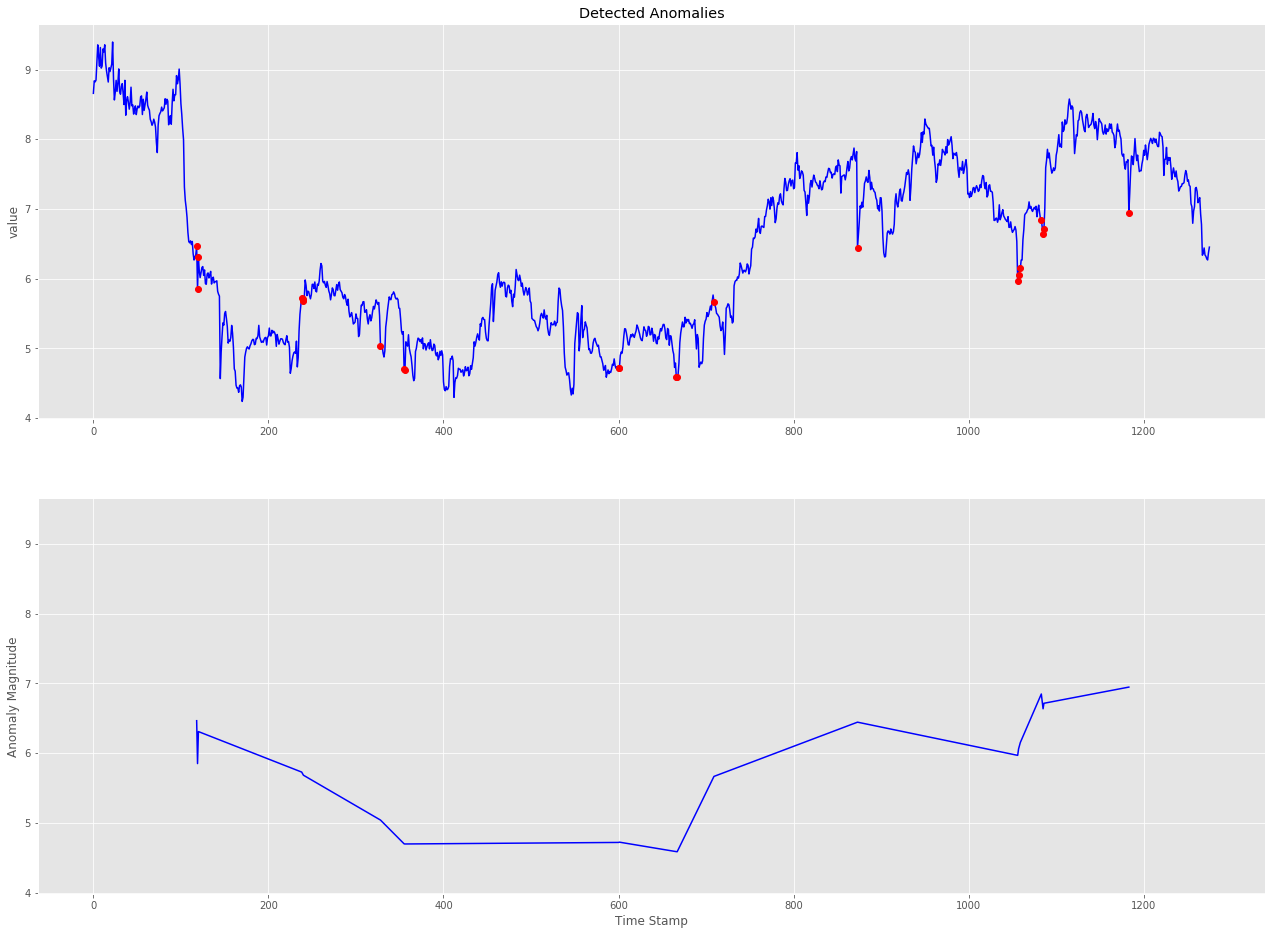

In [174]:
# make a nice plot
fig, ax = plt.subplots(2, 1, figsize=(22, 16))
#fig.autofmt_xdate(rotation=45)
ax[0].plot(df['timestamp'].reset_index(drop=True).index, df['count'], 'b')
ax[0].plot(results['anoms']['anoms'].index, results['anoms']['anoms'], 'ro')
ax[0].set_title('Detected Anomalies')
ax[1].set_xlabel('Time Stamp')
ax[0].set_ylabel('value')
ax[1].plot(results['anoms']['anoms'].index, results['anoms']['anoms'], 'b')
ax[1].set_ylabel('Anomaly Magnitude')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())

In [171]:
ax[0].get_xlim()

(-63.75, 1338.75)

int

In [75]:
# detect_anoms(df, num_obs_per_period=2, verbose=True)

In [70]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [71]:
df=df[df.item_name.str.contains('AK-47.*(Minimal Wear)')]

In [72]:
df.head()

,app,date,item_name,median_sell_price,quantity
846990,730,1.455775e+09,AK-47 | Fuel Injector (Minimal Wear),56.610,105
846991,730,1.455862e+09,AK-47 | Fuel Injector (Minimal Wear),54.187,96
846992,730,1.455948e+09,AK-47 | Fuel Injector (Minimal Wear),54.375,73
846993,730,1.456034e+09,AK-47 | Fuel Injector (Minimal Wear),52.994,70
846994,730,1.456121e+09,AK-47 | Fuel Injector (Minimal Wear),52.398,59


In [73]:
df.median_sell_price = df.median_sell_price / df.groupby('item_name').transform('mean').median_sell_price

In [74]:
df_copy = df.copy()

group by item, normalize each one, then separate and groupby date

# Number of item release dates

## START

In [15]:
dfcs = df[df.app == 730]
dfcs.date = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in dfcs.date]

/Applications/anaconda3/envs/capstone_env/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [16]:
dfcs['date_diff'] = dfcs.groupby('item_name')['date'].diff()

/Applications/anaconda3/envs/capstone_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
dfcs.head()

,app,date,item_name,median_sell_price,quantity,date_diff
604327,730,2016-08-19,Glock-18 | Weasel (Battle-Scarred),6.193,135,NaT
604328,730,2016-08-20,Glock-18 | Weasel (Battle-Scarred),5.103,166,1 days
604329,730,2016-08-21,Glock-18 | Weasel (Battle-Scarred),4.721,142,1 days
604330,730,2016-08-22,Glock-18 | Weasel (Battle-Scarred),4.302,98,1 days
604331,730,2016-08-23,Glock-18 | Weasel (Battle-Scarred),3.898,125,1 days


In [18]:
dfcs['max_diff'] = dfcs.groupby('item_name')['date_diff'].transform('max')

/Applications/anaconda3/envs/capstone_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
dfcs_daily = dfcs[dfcs.max_diff == pd.Timedelta('1 days 00:00:00')]

In [30]:
dfcs_daily['release'] = dfcs_daily.groupby('item_name')['date'].transform('min')

/Applications/anaconda3/envs/capstone_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
item_start_dates = dfcs_daily.release.unique()
release_delta = np.diff(np.sort(item_release_dates))[1:]

In [54]:
np.sort(item_release_dates)

array(['2013-08-13T00:00:00.000000000', '2013-08-14T00:00:00.000000000',
       '2013-08-15T00:00:00.000000000', '2013-08-29T00:00:00.000000000',
       '2013-09-20T00:00:00.000000000', '2013-09-21T00:00:00.000000000',
       '2013-09-22T00:00:00.000000000', '2013-11-07T00:00:00.000000000',
       '2013-11-08T00:00:00.000000000', '2013-11-09T00:00:00.000000000',
       '2013-11-28T00:00:00.000000000', '2013-11-29T00:00:00.000000000',
       '2013-11-30T00:00:00.000000000', '2013-12-19T00:00:00.000000000',
       '2014-02-06T00:00:00.000000000', '2014-02-13T00:00:00.000000000',
       '2014-02-21T00:00:00.000000000', '2014-02-22T00:00:00.000000000',
       '2014-02-27T00:00:00.000000000', '2014-02-28T00:00:00.000000000',
       '2014-05-02T00:00:00.000000000', '2014-06-12T00:00:00.000000000',
       '2014-07-02T00:00:00.000000000', '2014-07-11T00:00:00.000000000',
       '2014-07-12T00:00:00.000000000', '2014-07-15T00:00:00.000000000',
       '2014-08-05T00:00:00.000000000', '2014-08-14

In [56]:
import requests
from bs4 import BeautifulSoup

In [72]:
r = requests.get('https://www.csgodatabase.com/collections/')
bs = BeautifulSoup(r.content)

/Applications/anaconda3/envs/capstone_env/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Applications/anaconda3/envs/capstone_env/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [73]:
release_dates = bs.find_all(attrs={'class':'introduced-skinbox'})

In [74]:
release_dates = [a.text for a in release_dates]

In [75]:
release_dates

['19 September 2013',
 '14 August 2013',
 '14 August 2013',
 '1 July 2014',
 '1 May 2014',
 '8 August 2014',
 '26 May 2015',
 '1 July 2014',
 '14 August 2013',
 '27 November 2013',
 '26 May 2015',
 '14 August 2013',
 '27 November 2013',
 '27 November 2013',
 '14 August 2013',
 '27 November 2013',
 '14 August 2013',
 '14 August 2013',
 '1 July 2014',
 '26 May 2015',
 '27 November 2013',
 '27 November 2013',
 '14 August 2013']

In [76]:
r = requests.get('https://www.csgodatabase.com/cases/')
bs = BeautifulSoup(r.content)
release_dates2 = bs.find_all(attrs={'class':'introduced-skinbox'})
release_dates2 = [a.text for a in release_dates2]

/Applications/anaconda3/envs/capstone_env/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Applications/anaconda3/envs/capstone_env/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [86]:
item_release_dates = release_dates + release_dates2

In [96]:
import datetime
item_release_dates = release_dates + release_dates2
item_release_dates = np.unique(np.sort([datetime.datetime.strptime(x, '%d %B %Y') for x in item_release_dates]))

In [134]:
[print(x.date()) for x in item_release_dates]

2013-08-14
2013-09-19
2013-11-08
2013-11-27
2013-12-18
2014-02-12
2014-02-20
2014-05-01
2014-07-01
2014-07-10
2014-08-08
2014-11-11
2015-01-08
2015-04-15
2015-05-26
2015-09-17
2015-12-08
2016-02-17
2016-04-27
2016-06-15
2016-08-18
2016-11-28
2017-03-15
2017-05-23
2017-09-14
2018-02-15


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

/Applications/anaconda3/envs/capstone_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


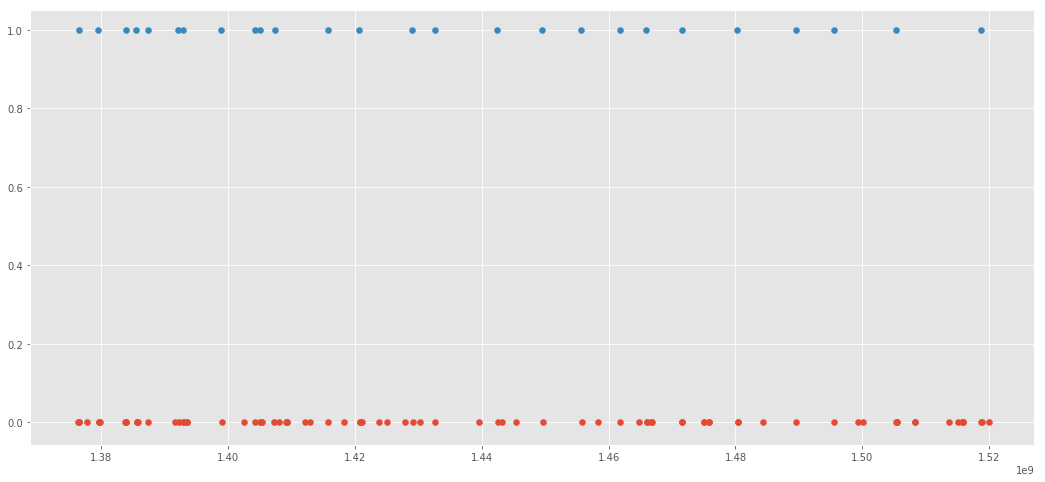

In [129]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(list(map(lambda x: (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'), item_start_dates)), [0]*len(item_start_dates))
ax.scatter(list(map(lambda x: datetime.datetime.timestamp(x), item_release_dates)), [1]*len(item_release_dates))

In [120]:
a = item_start_dates.astype(datetime.datetime)

In [127]:
item_start_dates[0]#[:19]

numpy.datetime64('2016-08-19T00:00:00.000000000')

## END

In [ ]:
not_daily = []
dfcs.date = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in dfcs.date]
for item in dfcs.item_name.unique():
    

In [ ]:
from heapq import nlargest
dfcs.date = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in dfcs.date]
col = dfcs.iloc[:,0]
n = len(col)
dfcs.groupby('item_name')['date'].transform(Series.diff())
for item in dfcs.item_name.unique():
    largest = nlargest(n, col)
    for x, y in zip(largest[1:], largest[:-1]):
        if int(round(np.timedelta64(y - x) / np.timedelta64(1, 's'))) > 86400:
        # drop every row with that item
        break

dfcs.groupby('')

In [ ]:
from heapq import nlargest
for item in np.random.choice(df.item_name.unique(), 5):
    df2 = df[(df['item_name'] == item)]
    df2 = df2[df2.date > 1420092000.0]
    df2 = df2[['date', 'median_sell_price']].reset_index(drop=True)
    df2.columns = ['timestamp', 'count']
    df2.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in df2.timestamp]
    col = df2.iloc[:,0]
    n = len(col)

    largest = nlargest(n, col)
    for x, y in zip(largest[1:], largest[:-1]):
        if int(round(np.timedelta64(y - x) / np.timedelta64(1, 's'))) != 86400:
            print(int(round(np.timedelta64(y - x) / np.timedelta64(1, 's'))))
            print(item)
            break